## Preprocesamiento y obtención de datos

Antes de comenzar a hacer variaciones de variaciones, tenemos que tener acceso a nuestra base de datos de paráfrasis. La razón por la cual en esta implementación se intentó utilizar lenguaje natural en inglés es por la falta de datos en cualquier otro idioma. Base de datos sacada de [PPDB](http://paraphrase.org/#/) (version pequeña).

In [1]:
import ppdb

path = 'C:/Users/jcvar/OneDrive/Escritorio/ppdb-2.0-s-all/ppdb-2.0-s-all.txt'

my_dict = ppdb.load_ppdb(path)

In [2]:
for x in my_dict[('huge', 'amounts')]:
    if type(x) is set:
        print(x)
        for y in x:
            print(y)
    print(str(type(x)))
my_dict[['huge', 'amounts']][0]

{('a', 'tremendous', 'amount'), ('a', 'significant', 'amount'), ('a', 'substantial', 'amount'), ('an', 'enormous', 'amount')}
('a', 'tremendous', 'amount')
('a', 'significant', 'amount')
('a', 'substantial', 'amount')
('an', 'enormous', 'amount')
<class 'set'>
<class 'ppdb.ppdb.TransformationDict'>


{('a', 'significant', 'amount'),
 ('a', 'substantial', 'amount'),
 ('a', 'tremendous', 'amount'),
 ('an', 'enormous', 'amount')}

Como funciona esta base de datos es que distintas palabras, frases e incluso oraciones completas, si al momento de pasar por un traductor, terminan diciendo lo mismo, se les considera un parafraseo. Es por eso que en este ejemplo podemos ver que la frase **'huge amounts'** es lo mismo que **'a tremendous amount'** o **'a significant amount'**.

Lo siguiente es el aumento de datos utilizando esta base de datos. Lo que hace esta función es reemplazar el numero de palabras que deseas (ngrams). Si deseas un ngram=1, la funcion reemplazará cada palabra individualmente por los 2 sinónimos que nuestra base de datos de paráfrasis considere. En caso de un ngram=2, tomará pares de palabras y reemplazará esta pequeña sub-oración con lo que la base de datos considere los 2 mejores parafraseos. Asimismo, los comandos SQL ligados con cada oración estarán ligados también con las oraciones generadas.
Al final hay una función que repite la función anterior con un ngram de 2, 3 y 4.
Por último, un pqueño ejemplo de como funciona esta función de aumento de datos.

In [2]:
def ngram_paraphrasing(sentence, pairs, ngram, sql_comand,factor=2):
    # Obtiene el largo de la oracion
    results = []
    length = len(sentence)
    # Define cuando parar
    for i in range(length - ngram):
        subsentence = []
        for j in range(ngram):
            # Crea la sub-oracion
            subsentence.append(sentence[i + j])
        # Si no encuentra la sub-oracion generada en la base de datos
        if not pairs[subsentence][0]:
            continue
        # Lo convierte a una lista para poder iterar sobre esta
        paraphrase_list = list(pairs[subsentence][0])
        # Cada parafraseo encontrado
        for paraphrasing in paraphrase_list[0:factor]:
            # Se reemplaza las palabras
            new_words = sentence[0:i] + list(paraphrasing) + sentence[i + ngram:]
            first_pair = ' '.join(new_words)
            results.append((first_pair, sql_comand))
    return results

def sentence_augmentation_paraphrasing(sentence, sql_comand):
    sentences = [(sentence, sql_comand)]
    words = sentence.split()
    sentences += ngram_paraphrasing(words, my_dict, 2, sql_comand)
    sentences += ngram_paraphrasing(words, my_dict, 3, sql_comand)
    sentences += ngram_paraphrasing(words, my_dict, 4, sql_comand)

    return sentences

my_sentence = 'show me the population with difficulty paying attention or learning simple things, group by population with difficulty paying attention or learning simple things in descending order'

my_sql_comand = 'select DISC12 from discapacidad group by DISC12 desc'

print(sentence_augmentation_paraphrasing(my_sentence, my_sql_comand))

[('show me the population with difficulty paying attention or learning simple things, group by population with difficulty paying attention or learning simple things in descending order', 'select DISC12 from discapacidad group by DISC12 desc'), ('is demonstrated by the population with difficulty paying attention or learning simple things, group by population with difficulty paying attention or learning simple things in descending order', 'select DISC12 from discapacidad group by DISC12 desc'), ('be demonstrated by the population with difficulty paying attention or learning simple things, group by population with difficulty paying attention or learning simple things in descending order', 'select DISC12 from discapacidad group by DISC12 desc'), ('show me specific populations with difficulty paying attention or learning simple things, group by population with difficulty paying attention or learning simple things in descending order', 'select DISC12 from discapacidad group by DISC12 desc'),

Aunque hay algunas oraciones que tienen mala gramática, hay varias otras que tienen sentido y se pueden considerar como parafrases.

### Creacion de variaciones

Ahora viene lo interesante, la creación de nuestra propia base de datos para nuestro problema en específico. Debido a la naturaleza de generación de variaciones de variaciones de variaciones, este problema se puede volver muy complejo muy rápido. Es por esto que se creó una pequeña clase llamada **Table**. Esta clase nos va a ayudar a modularizar cosas como el nombre de cada tabla, nombre de sus respectivas columnas y como referirse a cada columna en lenguaje natural.

In [3]:
class Table:
    def __init__(self, name, columns):
        self.name = name
        self.columns = columns
        self.natural_columns = ''

    def set_natural_columns(self, natural_columns):
        self.natural_columns = natural_columns

Con ayuda de la libreria pandas, podremos obtener el nombre de las columnas y ponerlas de forma automática.

In [4]:
import  pandas
import os

tables = []

# Checa todas las tablas en la carpeta
for filename in os.listdir('Data'):
    # Obtiene la ubicación del archivo
    path = os.path.join(os.getcwd(), 'Data', filename)
    # Abre el archivo
    with open(path) as f:
        # Cuenta el numero de columnas para que se pueda saltar la primera columan
        num_cols = len(f.readline().split(','))
    # Obtiene los datus
    df = pandas.read_csv(path, usecols=range(1, num_cols))
    # Da nombre y lista de columnas
    table = Table(filename[0:-4], list(df.columns))
    tables.append(table)

Para la obtención de como se llamarían las columnas en un lenguaje natural, este trabajo se tuvo que hacer manual

In [5]:
natural_cols_dis = ['state',
                    'handicapped population',
                    'femenine handicapped population',
                    'masculine handicapped population',
                    'handicapped population aged between 0 and 14',
                    'handicapped population aged between 15 and 59',
                    'handicapped population aged 60 and over',
                    'population with difficulty walking or moving',
                    'population with difficulty seeing even with glasses',
                    'population with difficulty speaking, communicating or conversing',
                    'population with hearing difficulty',
                    'population with difficulty getting dressed, bathing or eating',
                    'population with difficulty paying attention or learning simple things',
                    'population with mental difficulties',
                    'handicapped population entitled to health services']

natural_cols_econ = ['state',
                     'economically active population',
                     'femenine economically active population',
                     'masculine economically active population',
                     'non-economically active population',
                     'femenine non-economically active population',
                     'masculine non-economically active population',
                     'non-economically active population aged 12 and over that is dedicated to studying',
                     'non-economically active population aged 12 and over that is dedicated to household chores',
                     'non-economically active population aged 12 and over with mental or physical limitations that prevents them from working',
                     'non-economically active population with other reasons that prevents them from working']

natural_cols_educ = ['state',
                     'population aged between 3 and 5 that attends school',
                     'population aged between 3 and 5 that does not attend school',
                     'population aged between 6 and 11 that attends school',
                     'population aged between 6 and 11 that does not attend school',
                     'population aged between 12 and 14 that attends school',
                     'population aged between 12 and 14 that does not attend school',
                     'population aged between 8 and 14 that knows how to read and write',
                     'population aged between 8 and 14 that does not know how to read and write',
                     'population aged 15 and over that knows how to read and write',
                     'population aged 15 and over that does not know how to read and write',
                     'population aged 15 and over without schooling']

natural_cols_fecu = ['state',
                     'average number of children born alive',
                     'average number of children born alive from women aged between 15 and 49',
                     'percentage of women aged between 15 and 19 with at least 1 child born alive']

natural_cols_habl = ['state',
                     'population aged between 5 and 130 that speaks an indigenous language',
                     'population aged over 5 that speaks an indigenous language and does not speak spanish',
                     'population aged over 5 that speaks an indigenous language and spanish',
                     'population in indigenous households']

natural_cols_migr = ['state',
                     'population born in the state',
                     'femenine population born in the state',
                     'masculine population born in the state',
                     'population born in another state',
                     'masculine population born in another state',
                     'femenine population born in another state',
                     'population born in another country']

natural_cols_mort = ['state',
                     'percentage of stillborn children from women aged 12 and over']

natural_cols_pobl = ['state',
                     'total population',
                     'total femenine population',
                     'total masculine population',
                     'population aged between 0 and 2',
                     'population aged between 3 and 5',
                     'population aged between 6 and 11',
                     'population aged between 12 and 14',
                     'population aged between 15 and 29',
                     'population aged between 30 and 49',
                     'population aged between 50 and 59',
                     'population aged between 60 and 64',
                     'population aged 65 and over']

natural_cols_reli = ['state',
                     'population with catholic religion',
                     'population with protestant, evangelic or biblical religion',
                     'population with other religion',
                     'population with no religion']

natural_cols_salu = ['state',
                     'population entitle to health services',
                     'population not entitled to health services',
                     'population entitled to IMSS health services',
                     'population entitled to ISSSTE or state-owned ISSSTE health services',
                     'population entitled to popular insurance or new generation medical insurance',
                     'population entitled to Pemex, Sedena or Semar health services']

natural_cols_situ = ['state',
                     'single population aged 12 and over',
                     'married or joined population aged 12 and over',
                     'formerly married or joinned population aged 12 and over',
                     'married or joined population aged between 15 and 24']

tables[0].set_natural_columns(natural_cols_dis)
tables[1].set_natural_columns(natural_cols_econ)
tables[2].set_natural_columns(natural_cols_educ)
tables[3].set_natural_columns(natural_cols_fecu)
tables[4].set_natural_columns(natural_cols_habl)
tables[5].set_natural_columns(natural_cols_migr)
tables[6].set_natural_columns(natural_cols_mort)
tables[7].set_natural_columns(natural_cols_pobl)
tables[8].set_natural_columns(natural_cols_reli)
tables[9].set_natural_columns(natural_cols_salu)
tables[10].set_natural_columns(natural_cols_situ)

Las variaciones de lenguaje natural y comandos SQL, y sus repectivas variaciones tambien se tuvieron que hacer de forma manual. Se tuvo mucho cuidado al momento de escribirlas ya que es necesario que el índice de las órdenes en lenguaje natural coincidan con su respectivo comando de SQL.

In [6]:
# show me the [col_name] which values are [condition], group by [comp_col] in [order] order
# Conditions: less than, more than, equal to

variations = ['show me the [col_name]',
              'show me the [col_name], group by [comp_col]',
              'show me the [col_name], group by [comp_col] in [order] order',
              'show me the [col_name] where [condition]',
              'show me the [col_name] where [condition] group by [comp_col]',
              'show me the [col_name] where [condition] group by [comp_col] in [order] order',
              'show me the [col_name] where [condition] in [order] order',
              'show me the [col_name] in [order] order']

conditions = ['[col_name] is less than [cond_1]',
              '[col_name] is more than [cond_1]',
              '[col_name] is equal to [cond_1]']

order = ['ascending',
         'descending']

variations_sql = ['select [col_name_sql] from [table]',
                  'select [col_name_sql] from [table] group by [comp_col_sql]',
                  'select [col_name_sql] from [table] group by [comp_col_sql] [order_sql]',
                  'select [col_name_sql] from [table] where [condition_sql]',
                  'select [col_name_sql] from [table] where [condition_sql] group by [comp_col_sql]',
                  'select [col_name_sql] from [table] where [condition_sql] group by [comp_col_sql] [order_sql]',
                  'select [col_name_sql] from [table] where [condition_sql] [order_sql]',
                  'select [col_name_sql] from [table] [order_sql]']

conditions_sql = ['[col_name_sql] < [cond_1]',
                  '[col_name_sql] > [cond_1]',
                  '[col_name_sql] = [cond_1]']

order_sql = ['asc',
             'desc']

Estas son funciones que, de forma iterativa, generan las variaciones de las oraciones. Se modularizaron y la generación de las oraciones y sus respectivos comandos SQL se hara paso por paso.

In [7]:
# Obtiene variaciones con columnas de las tablas y sus respectivas variaciones SQL
def get_col_names(table:Table, variation:str, variation_sql:str):
    pairs = []
    for i in range(len(table.columns)):
        pair = (variation.replace('[col_name]', table.natural_columns[i]), variation_sql.replace('[col_name_sql]', table.columns[i]).replace('[table]', table.name), table.name)
        pairs.append(pair)
    return pairs

# Genera variaciones de condicinales
def replace_condition(pairs:list, conditions:list, conditions_sql:list):
    all_pairs = []
    for pair in pairs:
        if not '[condition]' in pair[0]:
            all_pairs.append(pair)
            continue
        for condition, condition_sql in zip(conditions, conditions_sql):
            new_pair = (pair[0].replace('[condition]', condition), pair[1].replace('[condition_sql]', condition_sql), pair[2])
            all_pairs.append(new_pair)
    return all_pairs

# Genera variaciones de orden ascendente o descendente
def replace_order(pairs:list, order:list, order_sql:list):
    all_pairs = []
    for pair in pairs:
        if not '[order]' in pair[0]:
            all_pairs.append(pair)
            continue
        for curr_order, curr_order_sql in zip(order, order_sql):
            new_pair = (pair[0].replace('[order]', curr_order), pair[1].replace('[order_sql]', curr_order_sql), pair[2])
            all_pairs.append(new_pair)
    return all_pairs

# Remplaza con las columnas complementarias de cada tabla correspondiente
def replace_comp_col(pairs:list, tables:list):
    all_pairs = []
    for pair in pairs:
        if not '[comp_col]' in pair[0]:
            all_pairs.append(pair)
            continue
        curr_table = pair[2]
        match curr_table:
            case 'discapacidad':
                for i in range(len(tables[0].columns)):
                    new_pair = (pair[0].replace('[comp_col]', tables[0].natural_columns[i]), pair[1].replace('[comp_col_sql]', tables[0].columns[i]), pair[2])
                    all_pairs.append(new_pair)
            case 'economia':
                for i in range(len(tables[1].columns)):
                    new_pair = (pair[0].replace('[comp_col]', tables[1].natural_columns[i]), pair[1].replace('[comp_col_sql]', tables[1].columns[i]), pair[2])
                    all_pairs.append(new_pair)
            case 'educacion':
                for i in range(len(tables[2].columns)):
                    new_pair = (pair[0].replace('[comp_col]', tables[2].natural_columns[i]), pair[1].replace('[comp_col_sql]', tables[2].columns[i]), pair[2])
                    all_pairs.append(new_pair)
            case 'fecundidad':
                for i in range(len(tables[3].columns)):
                    new_pair = (pair[0].replace('[comp_col]', tables[3].natural_columns[i]), pair[1].replace('[comp_col_sql]', tables[3].columns[i]), pair[2])
                    all_pairs.append(new_pair)
            case 'hablantes':
                for i in range(len(tables[4].columns)):
                    new_pair = (pair[0].replace('[comp_col]', tables[4].natural_columns[i]), pair[1].replace('[comp_col_sql]', tables[4].columns[i]), pair[2])
                    all_pairs.append(new_pair)
            case 'migracion':
                for i in range(len(tables[5].columns)):
                    new_pair = (pair[0].replace('[comp_col]', tables[5].natural_columns[i]), pair[1].replace('[comp_col_sql]', tables[5].columns[i]), pair[2])
                    all_pairs.append(new_pair)
            case 'mortalidad':
                for i in range(len(tables[6].columns)):
                    new_pair = (pair[0].replace('[comp_col]', tables[6].natural_columns[i]), pair[1].replace('[comp_col_sql]', tables[6].columns[i]), pair[2])
                    all_pairs.append(new_pair)
            case 'poblacion':
                for i in range(len(tables[7].columns)):
                    new_pair = (pair[0].replace('[comp_col]', tables[7].natural_columns[i]), pair[1].replace('[comp_col_sql]', tables[7].columns[i]), pair[2])
                    all_pairs.append(new_pair)
            case 'religion':
                for i in range(len(tables[8].columns)):
                    new_pair = (pair[0].replace('[comp_col]', tables[8].natural_columns[i]), pair[1].replace('[comp_col_sql]', tables[8].columns[i]), pair[2])
                    all_pairs.append(new_pair)
            case 'salud':
                for i in range(len(tables[9].columns)):
                    new_pair = (pair[0].replace('[comp_col]', tables[9].natural_columns[i]), pair[1].replace('[comp_col_sql]', tables[9].columns[i]), pair[2])
                    all_pairs.append(new_pair)
            case 'situacion_conyugal':
                for i in range(len(tables[10].columns)):
                    new_pair = (pair[0].replace('[comp_col]', tables[10].natural_columns[i]), pair[1].replace('[comp_col_sql]', tables[10].columns[i]), pair[2])
                    all_pairs.append(new_pair)
    return all_pairs

# Remplaza con las columnas de cada tabla correspondiente
def replace_col_name(pairs:list, tables:list):
    all_pairs = []
    for pair in pairs:
        if not '[col_name]' in pair[0]:
            all_pairs.append(pair)
            continue
        curr_table = pair[2]
        match curr_table:
            case 'discapacidad':
                for i in range(len(tables[0].columns)):
                    new_pair = (pair[0].replace('[col_name]', tables[0].natural_columns[i]), pair[1].replace('[col_name_sql]', tables[0].columns[i]), pair[2])
                    all_pairs.append(new_pair)
            case 'economia':
                for i in range(len(tables[1].columns)):
                    new_pair = (pair[0].replace('[col_name]', tables[1].natural_columns[i]), pair[1].replace('[col_name_sql]', tables[1].columns[i]), pair[2])
                    all_pairs.append(new_pair)
            case 'educacion':
                for i in range(len(tables[2].columns)):
                    new_pair = (pair[0].replace('[col_name]', tables[2].natural_columns[i]), pair[1].replace('[col_name_sql]', tables[2].columns[i]), pair[2])
                    all_pairs.append(new_pair)
            case 'fecundidad':
                for i in range(len(tables[3].columns)):
                    new_pair = (pair[0].replace('[col_name]', tables[3].natural_columns[i]), pair[1].replace('[col_name_sql]', tables[3].columns[i]), pair[2])
                    all_pairs.append(new_pair)
            case 'hablantes':
                for i in range(len(tables[4].columns)):
                    new_pair = (pair[0].replace('[col_name]', tables[4].natural_columns[i]), pair[1].replace('[col_name_sql]', tables[4].columns[i]), pair[2])
                    all_pairs.append(new_pair)
            case 'migracion':
                for i in range(len(tables[5].columns)):
                    new_pair = (pair[0].replace('[col_name]', tables[5].natural_columns[i]), pair[1].replace('[col_name_sql]', tables[5].columns[i]), pair[2])
                    all_pairs.append(new_pair)
            case 'mortalidad':
                for i in range(len(tables[6].columns)):
                    new_pair = (pair[0].replace('[col_name]', tables[6].natural_columns[i]), pair[1].replace('[col_name_sql]', tables[6].columns[i]), pair[2])
                    all_pairs.append(new_pair)
            case 'poblacion':
                for i in range(len(tables[7].columns)):
                    new_pair = (pair[0].replace('[col_name]', tables[7].natural_columns[i]), pair[1].replace('[col_name_sql]', tables[7].columns[i]), pair[2])
                    all_pairs.append(new_pair)
            case 'religion':
                for i in range(len(tables[8].columns)):
                    new_pair = (pair[0].replace('[col_name]', tables[8].natural_columns[i]), pair[1].replace('[col_name_sql]', tables[8].columns[i]), pair[2])
                    all_pairs.append(new_pair)
            case 'salud':
                for i in range(len(tables[9].columns)):
                    new_pair = (pair[0].replace('[col_name]', tables[9].natural_columns[i]), pair[1].replace('[col_name_sql]', tables[9].columns[i]), pair[2])
                    all_pairs.append(new_pair)
            case 'situacion_conyugal':
                for i in range(len(tables[10].columns)):
                    new_pair = (pair[0].replace('[col_name]', tables[10].natural_columns[i]), pair[1].replace('[col_name_sql]', tables[10].columns[i]), pair[2])
                    all_pairs.append(new_pair)
    return all_pairs

# Utiliza la función anterior con la base de datos de parafraseo para aumentar los datos
def augment_pairs(pairs:list):
    all_pairs = []
    for pair in pairs:
        new_pairs = sentence_augmentation_paraphrasing(pair[0], pair[1])
        all_pairs += new_pairs
    return all_pairs

Con todo en su respectivo lugar, queda generar y guardar en un archivo nuestra base de datos

In [8]:
all_pairs = []
for table in tables:
    for i in range(len(variations)):
        pairs = get_col_names(table, variations[i], variations_sql[i])
        all_pairs += pairs

all_pairs = replace_condition(all_pairs, conditions, conditions_sql)
all_pairs = replace_order(all_pairs, order, order_sql)
all_pairs = replace_comp_col(all_pairs, tables)
all_pairs = replace_col_name(all_pairs, tables)
all_pairs = augment_pairs(all_pairs)

with open('variations.txt', 'w') as f:
    for pairs in all_pairs:
        f.write(pairs[0] + '\t' + pairs[1] + '\n')

## Implementación del modelo

Con la generación de la base de datos completada, es hora de implementar el modelo. Este modelo fue basado en el modelo presentado por Eileen Pangu en [Towards Data Science](https://towardsdatascience.com/end-to-end-attention-based-machine-translation-model-with-minimum-tensorflow-code-ae2f08cc8218) y fue modificado para poder resokver nuestra problemática.
Se empieza por separar el dataset en un dataset de lenguaje natural y uno de comandos SQL.

In [1]:
import tensorflow as tf

def split(text):
    parts = tf.strings.split(text, sep='\t')
    return parts[0], parts[1]

full_dataset = tf.data.TextLineDataset(['variations.txt']).map(split)
nat_dataset = full_dataset.map(lambda nat, sql: nat)
sql_dataset = full_dataset.map(lambda nat, sql: sql)

Después de eso, estandarizamos nuestros datasets para después pasarlos por una capa de Vectorizado de Texto. Y después se adapta esta capa. Al final podemos ver nuestro vocabulario que obtuvimos después de este proceso.

In [2]:
def standardize(text):
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

nat_text_processor = tf.keras.layers.TextVectorization(standardize=standardize, max_tokens=5000)
sql_text_processor = tf.keras.layers.TextVectorization(standardize=standardize, max_tokens=5000)

nat_text_processor.adapt(nat_dataset.batch(128))
sql_text_processor.adapt(sql_dataset.batch(128))

print(nat_text_processor.get_vocabulary())

['', '[UNK]', 'population', 'and', 'aged', 'by', 'is', 'between', 'the', '[START]', '[END]', 'cond', 'where', 'that', 'group', 'to', 'show', 'me', 'in', 'order', 'than', 'over', 'with', 'not', 'active', 'school', 'does', 'descending', 'ascending', 'handicapped', 'write', 'read', 'how', 'or', 'more', 'noneconomically', 'difficulty', 'state', 'less', ',', 'equal', 'attend', 'attends', 'masculine', 'femenine', 'know', 'knows', 'entitled', 'health', 'services', 'total', 'of', 'born', 'working', 'economically', 'demonstrated', 'from', 'mental', 'general', 'dedicated', 'them', 'prevents', 'be', 'without', 'schooling', 'populations', 'years', 'are', 'attention', 'chores', 'things', 'simple', 'learning', 'other', 'studying', 'household', 'equivalent', 'hearing', 'another', 'difficulties', 'walking', 'moving', 'speaking', 'seeing', 'paying', 'glasses', 'getting', 'even', 'eating', 'dressed', 'conversing', 'communicating', 'bathing', 'was', 'reasons', 'physical', 'limitations', 'indigenous', 'ta

Ya que puede que nuestro usuario escriba los comandos de forma diferente, ponemos una capa de incrustación de palabras cuyos pesos estaran congelados. Esto nos va a ayudar a evitar que nuestro modelo se encuentre con palabras que no haya tokenizado o que no se encuentre en el dataset.

In [9]:
import numpy as np
import pandas as pd

embeddings_index = {}
with open('glove.6B/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

fixed_embedding_matrix = np.zeros((len(nat_text_processor.get_vocabulary()), 100))
for i, word in enumerate(nat_text_processor.get_vocabulary()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        fixed_embedding_matrix[i] = embedding_vector

fixed_embedding = tf.keras.layers.Embedding(
    len(nat_text_processor.get_vocabulary()),
    100,
    embeddings_initializer=tf.keras.initializers.Constant(fixed_embedding_matrix),
    trainable=False,
    mask_zero=True)

Después queda crear el modelo. Al momento de crearse, el modelo obtiene el procesador de texto natural, el procesador de comandos sql y la capa de incrustación de palabras congelada.
Al momento de que el modelo se manda a llamar (principalmente en entrenamiento), este obtendra los tokens del input, los pasara por el codificador y de ahí obtendrá los estados. Después de esto, se obtendrán los tokens del comando SQL proporcionado. Pasara por la capa atención para despues pasar por el decodificador.

In [8]:
class Nl2SqlTranslator(tf.keras.Model):
    def __init__(self, nl_text_processor, sql_text_processor, fixed_embedding, unit=128):
        super().__init__()
        # Natural language
        self.nl_text_processor = nl_text_processor
        self.nl_voba_size = len(nl_text_processor.get_vocabulary())
        self.nl_embedding = tf.keras.layers.Embedding(
            self.nl_voba_size,
            output_dim=unit,
            mask_zero=True)
        self.fixed_embedding = fixed_embedding
        self.nl_rnn = tf.keras.layers.Bidirectional(layer=tf.keras.layers.LSTM(int(unit/2), return_sequences=True, return_state=True))
        # Attention
        self.attention = tf.keras.layers.Attention()
        # SQL
        self.sql_text_processor = sql_text_processor
        self.sql_voba_size = len(sql_text_processor.get_vocabulary())
        self.sql_embedding = tf.keras.layers.Embedding(
            self.sql_voba_size,
            output_dim=unit,
            mask_zero=True)
        self.sql_rnn = tf.keras.layers.LSTM(unit, return_sequences=True, return_state=True)
        # Output
        self.out = tf.keras.layers.Dense(self.sql_voba_size)

    def call(self, nl_text, sql_text, training=True):
        nl_tokens = self.nl_text_processor(nl_text)
        nl_vectors = self.nl_embedding(nl_tokens, training=training)
        nl_fixed_vectors = self.fixed_embedding(nl_tokens)
        # nl_combined_vectors = tf.concat([nl_vectors, nl_fixed_vectors], -1)
        nl_rnn_out, fhstate, fcstate, bhstate, bcstate = self.nl_rnn(nl_vectors, training=training)
        nl_hstate = tf.concat([fhstate, bhstate], -1)
        nl_cstate = tf.concat([fcstate, bcstate], -1)

        sql_tokens = self.sql_text_processor(sql_text)
        expected = sql_tokens[:,1:]

        teacher_forcing = sql_tokens[:,:-1]
        sql_vectors = self.sql_embedding(teacher_forcing, training=training)
        sql_in = self.attention(inputs=[sql_vectors,nl_rnn_out], mask=[sql_vectors._keras_mask, nl_rnn_out._keras_mask], training=training)

        trans_vectors, _, _ = self.sql_rnn(sql_in, initial_state=[nl_hstate, nl_cstate], training=training)
        out = self.out(trans_vectors, training=training)
        return out, expected, out._keras_mask

Ahora falta entrenarlo. Aquí es donde la implementación toma un giro no optimizado debido al uso de un ciclo **for** para iterar sobre todo nuestro dataset.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import time


def train(epochs, model, batch=64, shuffle=1000):
    # Se define la funcion de perdida
    loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True,
        reduction=tf.keras.losses.Reduction.NONE)
    # Definicion de algoritmo de optimizacion
    opt = tf.keras.optimizers.Adam()
    losses = []
    # Aleatoriedad en el dataset
    ds = full_dataset.shuffle(shuffle).batch(batch).cache()
    for epoch in range(epochs):
        # Epoch e inicio de toma de tiempo
        epoch_losses = []
        start_time = time.time()
        # Para cada fila en nuestro dataset
        for eng_text, spa_text in ds:
            # Guarda valores para calculo diferencial mas rapido
            with tf.GradientTape() as tape:
                logits, expected, mask = model(eng_text, spa_text)
                # Termina el proceso de red neuronal y calcula la perdida
                loss = loss_fcn(expected, logits)
                loss = tf.ragged.boolean_mask(loss, mask)
                loss = tf.reduce_sum(loss) * (1. / batch)
                epoch_losses.append(loss.numpy())
                # Saca gradientes
                grads = tape.gradient(loss, model.trainable_weights)
                opt.apply_gradients(zip(grads, model.trainable_weights))
        # Obtiene perdida al final del epoch
        losses.append(np.mean(epoch_losses))
        print('Trained epoch: {}; loss: {}'.format(epoch, losses[epoch]))
        print(f'Time elapsed in seconds: {time.time() - start_time}')
    # Grafica de resultados
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Losses')

Ahora entrenaremos el modelo. Debido a la pobre implementación y gran cantidad de datos a utilizar, el entrenamiento solamente se hará con 5 epochs.

Trained epoch: 0; loss: 0.05051204189658165
Time elapsed in seconds: 2356.7697534561157
Trained epoch: 1; loss: 0.010642411187291145
Time elapsed in seconds: 2313.3394722938538
Trained epoch: 2; loss: 0.008154137060046196
Time elapsed in seconds: 2306.1291120052338
Trained epoch: 3; loss: 0.008491545915603638
Time elapsed in seconds: 2331.616354703903
Trained epoch: 4; loss: 0.006217396352440119
Time elapsed in seconds: 2408.2197473049164


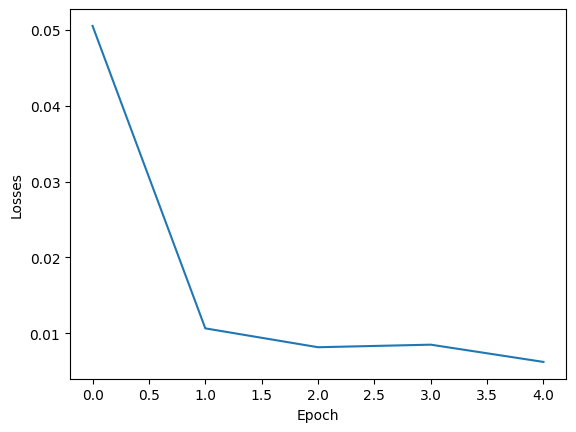

In [22]:
model = Nl2SqlTranslator(nat_text_processor, sql_text_processor, fixed_embedding)

train(5, model)

El modelo muestra un rendimiento bastante prometedor, ahora es cuestión de hacer inferencias con el modelo

Para poder sacar inferencias, tenemos que hacer el mismo proceso que se hizo al entrenar, pasando por toda la red neuronal, solamente que aqui paramos al momento de obtener los valores del decodificador ya que esa será la predicción de nuestro modelo.

In [26]:
def translate(nat_text, model:Nl2SqlTranslator, max_seq=100):
    nl_tokens = model.nl_text_processor([nat_text])
    nl_vectors = model.nl_embedding(nl_tokens, training=False)
    nl_rnn_out, fhstate, fcstate, bhstate, bcstate = model.nl_rnn(nl_vectors, training=False)
    nl_hstate = tf.concat([fhstate, bhstate], -1)
    nl_cstate = tf.concat([fcstate, bcstate], -1)
    state = [nl_hstate, nl_cstate]
    print(nl_rnn_out.shape)

    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=model.sql_text_processor.get_vocabulary(),
        mask_token='')
    trans = ['[START]']
    vectors = []

    for i in range(max_seq):
        token = index_from_string([[trans[i]]])
        vector = model.sql_embedding(token, training=False)
        vectors.append(vector)
        query = tf.concat(vectors, axis=1)
        context = model.attention(inputs=[query, nl_rnn_out], training=False)
        trans_vector, hstate, cstate = model.sql_rnn(context[:,-1:,:], initial_state=state, training=False)
        state = [hstate, cstate]
        out = model.out(trans_vector)
        out = tf.squeeze(out)
        word_index = tf.math.argmax(out)
        word = model.sql_text_processor.get_vocabulary()[word_index]
        trans.append(word)
        if word == '[END]':
            trans = trans[:-1]
            break
    _, atts = model.attention(inputs=[vectors, nl_rnn_out], return_attention_scores=True, training=False)
    return ' '.join(trans[1:]), atts

Ahora intentemos traducir

In [36]:
print('show me the general population in ascending order')
print(translate('show me the general population in ascending order', model))

SyntaxError: invalid syntax (2494688461.py, line 1)

Tristemente, nuestro modelo siempre genera un query similar al que se muestra anteriormente. Cada epoch y tiempo de entrenamiento es bastante alto, y para resolver este problema necesitariamos a todo nuestro equipo trabajando en esto, pero nuestro tiempo es limitado y este modelo no es lo único que se debe hacer, es por esto que hasta aqui dejamos este modelo, pero sin no antes reconocer que, con un problema más sencillo, este modelo pudo haber funcionado de maravilla.